In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data Exploration

In [4]:
# Load dataset
data = pd.read_csv("Data/creditcard.csv")

# Explore
print(data.head())
print(data.describe())
print(data['Class'].value_counts())  # Only for exploration, not used for training


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

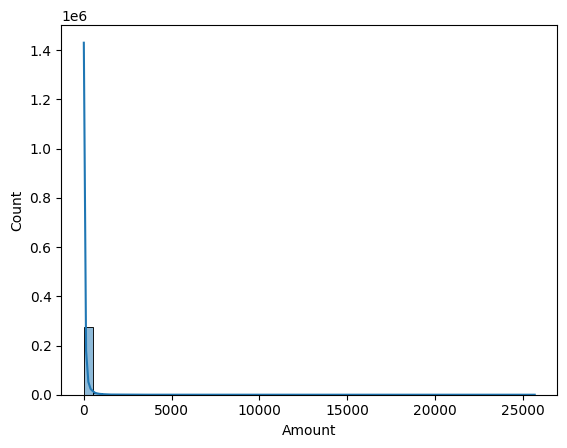

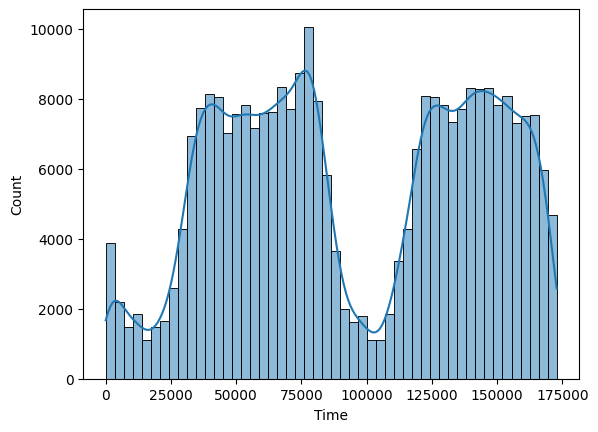

In [5]:
# Distribution plots
sns.histplot(data['Amount'], bins=50, kde=True)
plt.show()

sns.histplot(data['Time'], bins=50, kde=True)
plt.show()

### Step 2: Preprocessing

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Drop label for unsupervised training
X = data.drop('Class', axis=1)

In [8]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

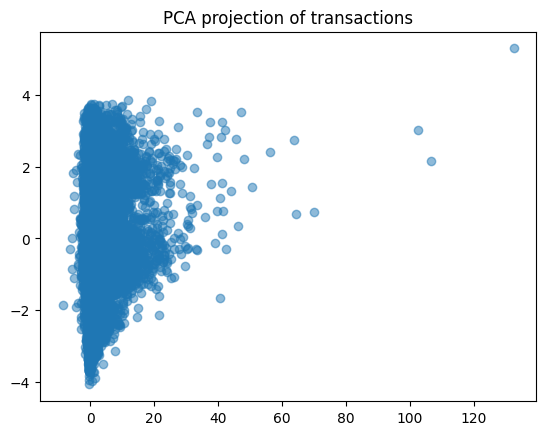

In [9]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.5)
plt.title('PCA projection of transactions')
plt.show()


In [10]:
#Isolation Forest
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.0017, random_state=42)  # approx fraud rate
y_pred_iso = iso.fit_predict(X_scaled)
y_pred_iso = [1 if i == -1 else 0 for i in y_pred_iso]  # -1 = anomaly


In [11]:
#One-Class SVM
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(nu=0.0017, kernel='rbf', gamma=0.01)
y_pred_svm = ocsvm.fit_predict(X_scaled)
y_pred_svm = [1 if i == -1 else 0 for i in y_pred_svm]


In [13]:
##Autoencoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import numpy as np

In [14]:
input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(14, activation='relu')(input_layer)
encoded = Dense(7, activation='relu')(encoded)
decoded = Dense(14, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=10, batch_size=256, validation_split=0.1)


Epoch 1/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.9481 - val_loss: 0.8642
Epoch 2/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.8604 - val_loss: 0.8471
Epoch 3/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.8447 - val_loss: 0.8359
Epoch 4/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8374 - val_loss: 0.8297
Epoch 5/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8332 - val_loss: 0.8261
Epoch 6/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8302 - val_loss: 0.8238
Epoch 7/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8277 - val_loss: 0.8222
Epoch 8/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.8254 - val_loss: 0.8196
Epoch 9/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.8234 - val_loss: 0.8196
Epoch 10/10
1002/1002 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.8215 - val_loss: 0.8172


In [15]:
# Reconstruction error
predictions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)
threshold = np.percentile(mse, 99.83)  # match fraud rate ~0.17%
y_pred_ae = [1 if e > threshold else 0 for e in mse]


8901/8901 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step


### Evaluation

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = data['Class']

# Evaluate Isolation Forest
print("Isolation Forest:")
print(classification_report(y_true, y_pred_iso))

Isolation Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.26      0.25      0.26       492

    accuracy                           1.00    284807
   macro avg       0.63      0.63      0.63    284807
weighted avg       1.00      1.00      1.00    284807



In [17]:
# Evaluate One-Class SVM
print("One-Class SVM:")
print(classification_report(y_true, y_pred_svm))

# Evaluate Autoencoder
print("Autoencoder:")
print(classification_report(y_true, y_pred_ae))


One-Class SVM:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.10      0.11      0.11       492

    accuracy                           1.00    284807
   macro avg       0.55      0.56      0.55    284807
weighted avg       1.00      1.00      1.00    284807

Autoencoder:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.24      0.23      0.23       492

    accuracy                           1.00    284807
   macro avg       0.62      0.62      0.62    284807
weighted avg       1.00      1.00      1.00    284807

